In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
# esta linha
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd

In [2]:
# Paths to the train and test directories
train_dir = r'C:\Users\Gabriel Benga\Documents\Python\TCC\TCC\TCC\Datasets\df1-banco com varias posicoes de mao com diferentes ambientes tbm\train'
test_dir = r'C:\Users\Gabriel Benga\Documents\Python\TCC\TCC\TCC\Datasets\df1-banco com varias posicoes de mao com diferentes ambientes tbm\test'

# Prepare dataset
all_data = []
for folder in os.listdir(train_dir):
    label_folder = os.path.join(train_dir, folder)
    onlyfiles = [{'label': folder, 'path': os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles

data_df = pd.DataFrame(all_data)
x_train, x_holdout = train_test_split(data_df, test_size=0.10, random_state=42, stratify=data_df[['label']])
x_train, x_test = train_test_split(x_train, test_size=0.25, random_state=42, stratify=x_train[['label']])

In [3]:
# Image data generator
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale=1/255.0)
validation_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

holdout_generator = test_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 23431 validated image filenames belonging to 21 classes.
Found 7811 validated image filenames belonging to 21 classes.
Found 3472 validated image filenames belonging to 21 classes.


In [4]:
# Definir e compilar o modelo
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(no_of_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Gabriel Benga\Documents\Python\Python-sistemas\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

Epoch 1/5


C:\Users\Gabriel Benga\Documents\Python\Python-sistemas\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 513ms/step - accuracy: 0.3087 - loss: 2.3337 - val_accuracy: 0.8733 - val_loss: 0.4898
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 395ms/step - accuracy: 0.9065 - loss: 0.3458 - val_accuracy: 0.9672 - val_loss: 0.1151
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.9852 - loss: 0.0597 - val_accuracy: 0.9840 - val_loss: 0.0577
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 408ms/step - accuracy: 0.9935 - loss: 0.0241 - val_accuracy: 0.9908 - val_loss: 0.0305
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.9923 - loss: 0.0286 - val_accuracy: 0.9974 - val_loss: 0.0139


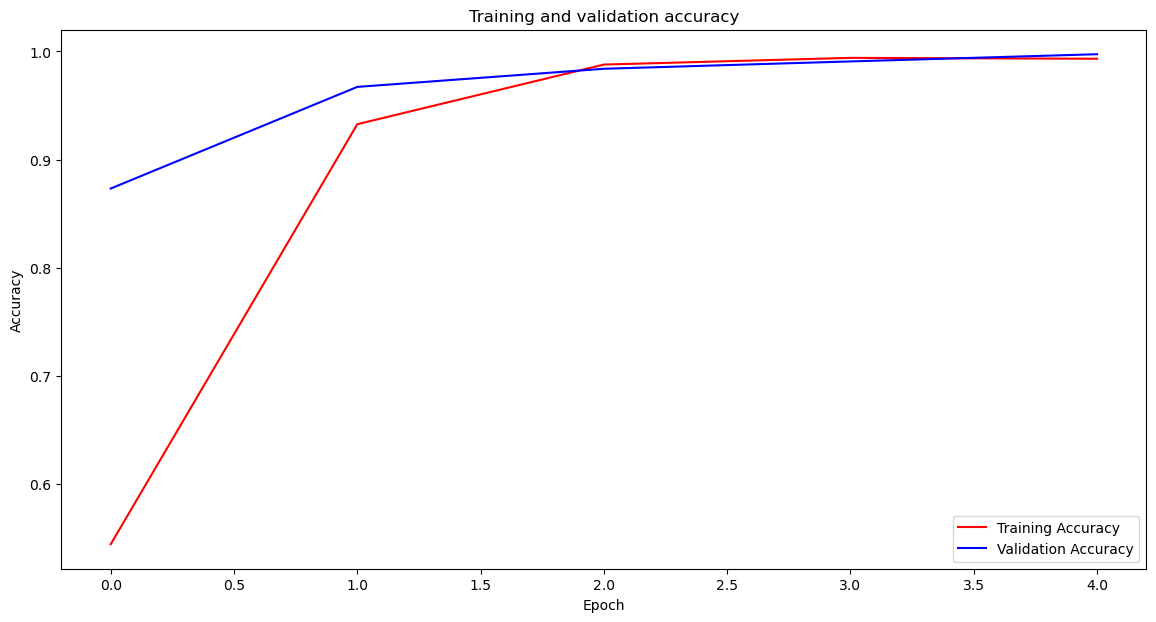

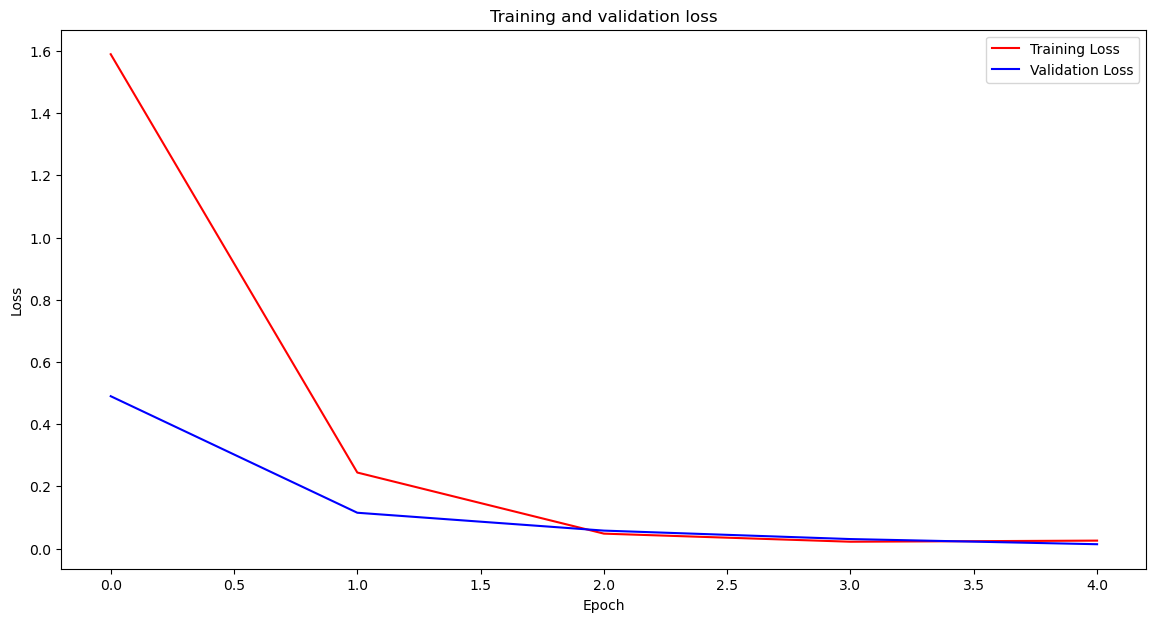

In [6]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.show()

In [7]:
# Predictions
predictions = model.predict(holdout_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Save model
model.save('modelo-treinado.h5')


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step


              precision    recall  f1-score   support

           A       0.05      0.05      0.05       169
           B       0.07      0.07      0.07       166
           C       0.07      0.07      0.07       169
           D       0.05      0.05      0.05       165
           E       0.05      0.05      0.05       167
           F       0.06      0.06      0.06       165
           G       0.04      0.04      0.04       165
           I       0.08      0.08      0.08       165
           L       0.07      0.07      0.07       165
           M       0.05      0.05      0.05       165
           N       0.06      0.06      0.06       165
           O       0.04      0.04      0.04       165
           P       0.06      0.06      0.06       165
           Q       0.04      0.04      0.04       165
           R       0.05      0.05      0.05       165
           S       0.04      0.04      0.04       165
           T       0.04      0.04      0.04       161
           U       0.07    